# Extract along-slope velocity (for Taimoor to do GMM)

Surface velocity, monthly data, last 10 years of RYF run

In [1]:
# Load modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
import xgcm

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores

In [2]:
client = Client() # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34871,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:46819,Total threads: 4
Dashboard: /proxy/36189/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:38887,


Nominate a database from which to load the data and define an experiment

In [3]:
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

### Topographic gradient

In [4]:
lat_slice = slice(-80, -59)

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)

# Import grid cell length
dxu = cc.querying.getvar(expt, 'dxu', session, n=1)
dyu = cc.querying.getvar(expt, 'dyu', session, n=1)

# Change coordinate name
dxu.coords['ni'] = hu['xu_ocean'].values
dxu.coords['nj'] = hu['yu_ocean'].values
dyu.coords['ni'] = hu['xu_ocean'].values
dyu.coords['nj'] = hu['yu_ocean'].values
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))

# Select latitude range
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()
dxu = dxu.sel(yu_ocean=lat_slice)
dxu = dxu.load()
dyu = dyu.sel(yu_ocean=lat_slice)
dyu = dyu.load()

Calculate grad h using xgcm functions

In [5]:
# Load model grid information
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [8]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')

# Same as: (other option)
#dhu_dx = grid.interp(grid.diff(ds.hu, 'X'), 'X') / ds.dxu
#dhu_dy = grid.interp(grid.diff(ds.hu, 'Y', boundary='extend'), 'Y', boundary='extend') / ds.dyu

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

In [9]:
# Calculate the magnitude of the topographic slope
slope = np.sqrt(dhu_dx**2 + dhu_dy**2)

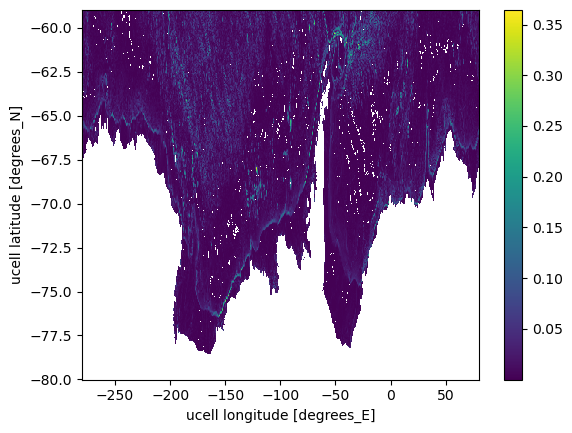

In [10]:
# Note: some values are zero which becomes an issue later on when rotating the velocities.
# We will use the original u, v components in those cases.
slope.where(slope!=0, np.nan).plot()

### Along-slope velocity

In [11]:
# Last 10 years of RYF simulation
year = np.arange(2170, 2180, 1)
for ii in year:
    print(ii)
    start_time = str(ii) + '-01-01'
    end_time   = str(ii) + '-12-31'

    # Import velocities
    u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
    u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)
    v = cc.querying.getvar(expt, 'v', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
    v = v.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)

    # Rotate velocities
    # Along-slope velocity
    u_along_tmp = u*dhu_dy/slope - v*dhu_dx/slope
    # Cross-slope velocity
    # v_cross_tmp = u*dhu_dx/slope + v*dhu_dy/slope

    # Use zonal velocity where topographic slope is zero (gives nans due to devision by slope value above), in some cases merid velocity could be more appropriate?
    u_along_tmp = u_along_tmp.where(np.isnan(u_along_tmp)==False, u).load()   # slope!=0

    if ii == 2170:
        u_along = u_along_tmp
    elif ii >2170:
        u_along = xr.concat([u_along, u_along_tmp], dim='time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  retu

### Save along-slope velocity

In [12]:
u_along.to_netcdf('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/along_slope_3D_vels_RYF.nc')